In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.uk import UniversalKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
import random

np.random.seed(33)
random.seed(33)

### Choose the Collaborative Variable

In [10]:
# This is chosen by each correlation
selected_variables = ['variable1', 'variable4']

collaborative_variables = {
    'variable1': pd.read_csv('Attachment 1/F1_collaborative_variable1.csv')['Target Property'],
    'variable2': pd.read_csv('Attachment 1/F1_collaborative_variable2.csv')['Target Property'],
    'variable3': pd.read_csv('Attachment 1/F1_collaborative_variable3.csv')['Target Property'],
    'variable4': pd.read_csv('Attachment 1/F1_collaborative_variable4.csv')['Target Property']
}

selected_data = {var: collaborative_variables[var] for var in selected_variables}

### Choose Variation Functions

In [ ]:
# This is chosen by test below
variogram_models = {
    'variable1': 'gaussian',
    'variable2': 'gaussian',
    'variable3': 'gaussian',
    'variable4': 'gaussian'
}

selected_variogram_models = {var: variogram_models[var] for var in selected_variables}

# 1. Original Plot

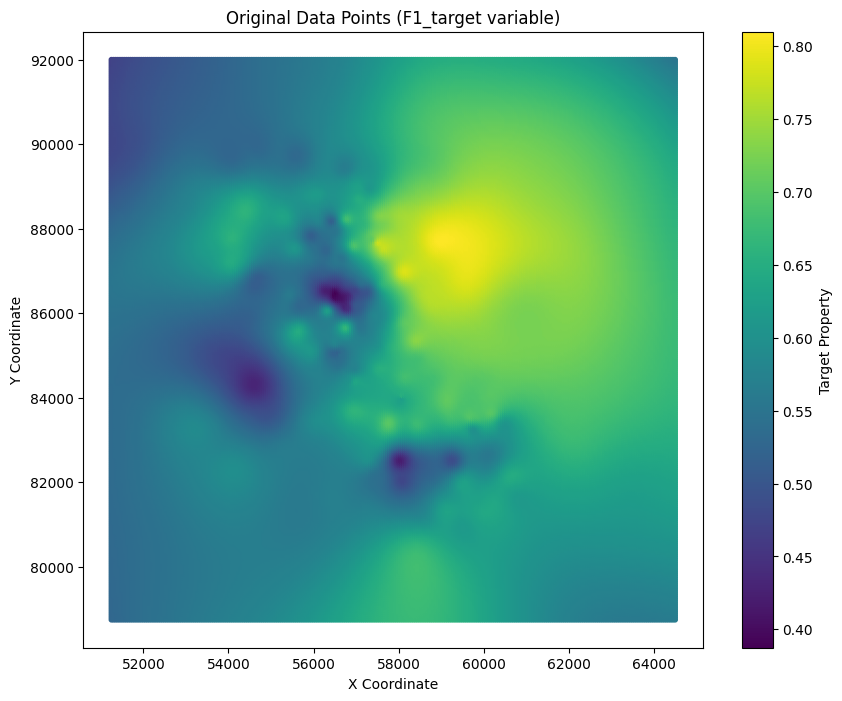

In [ ]:
# ------ 1. Original Plot ------ #
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=z, cmap='viridis', s=10)
plt.colorbar(label='Target Property')  
plt.title('Original Data Points (F1_target variable)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# save the original data points as a png file
plt.savefig('Original_Data_Points.png')
plt.show()

# 2. Prediction Plot &
# 3. Error Plot

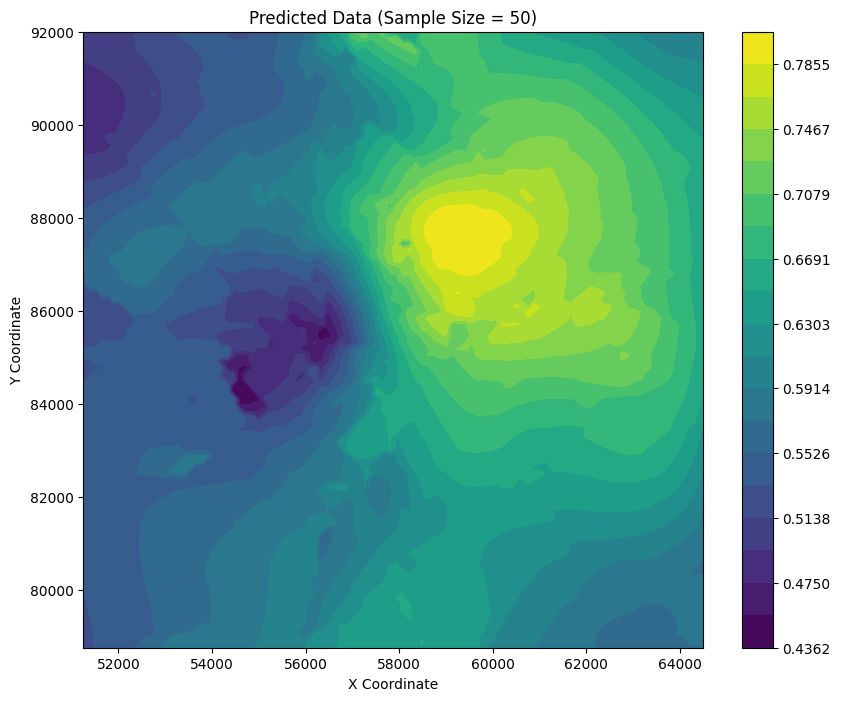

Sample Size = 50:
  MSE: 0.000766
  RMSE: 0.027679
  MAE: 0.016712
--------------------------------------------------


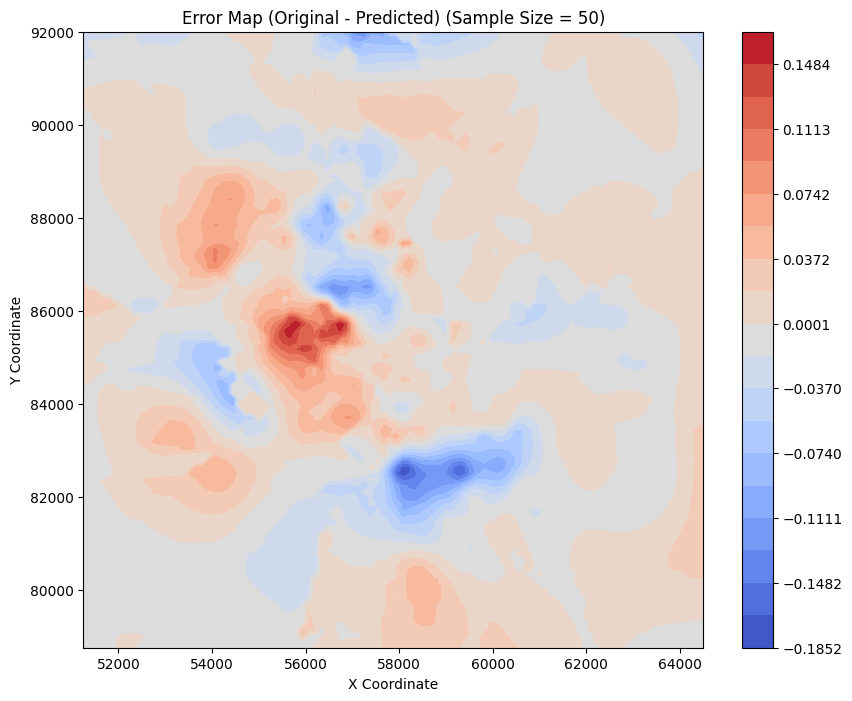

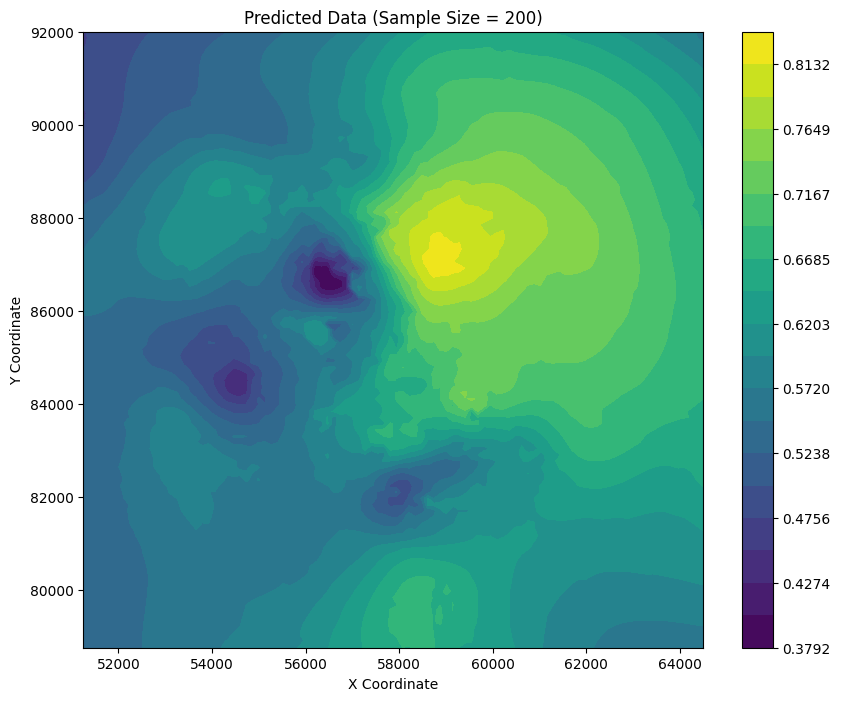

Sample Size = 200:
  MSE: 0.000168
  RMSE: 0.012948
  MAE: 0.006117
--------------------------------------------------


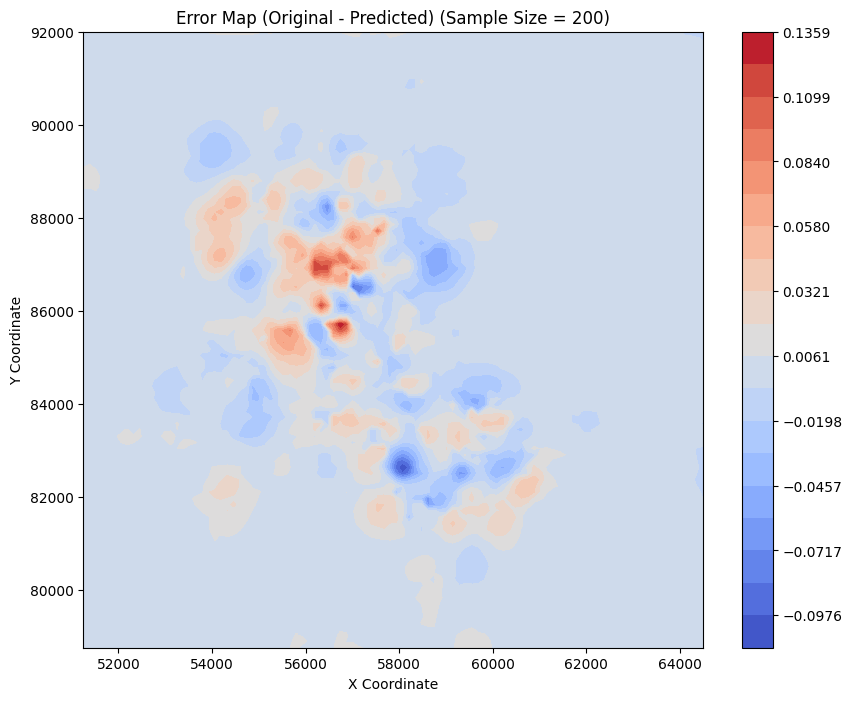

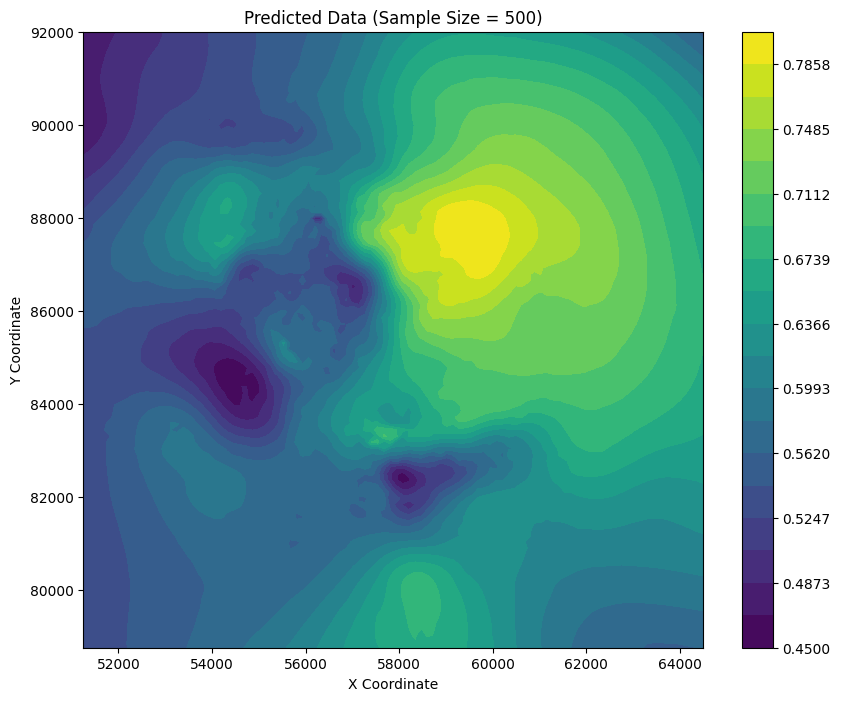

Sample Size = 500:
  MSE: 0.000068
  RMSE: 0.008262
  MAE: 0.002826
--------------------------------------------------


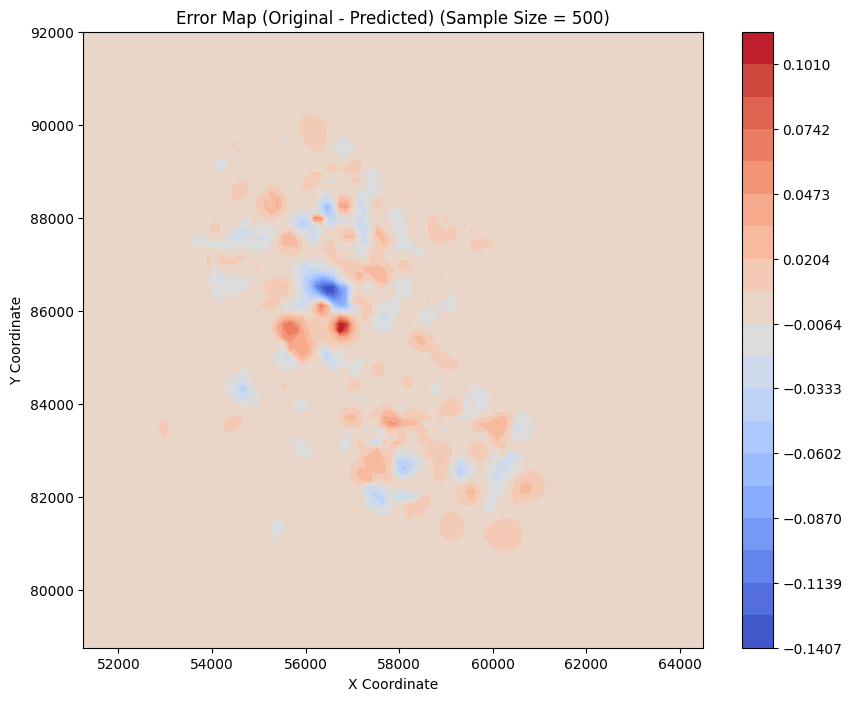

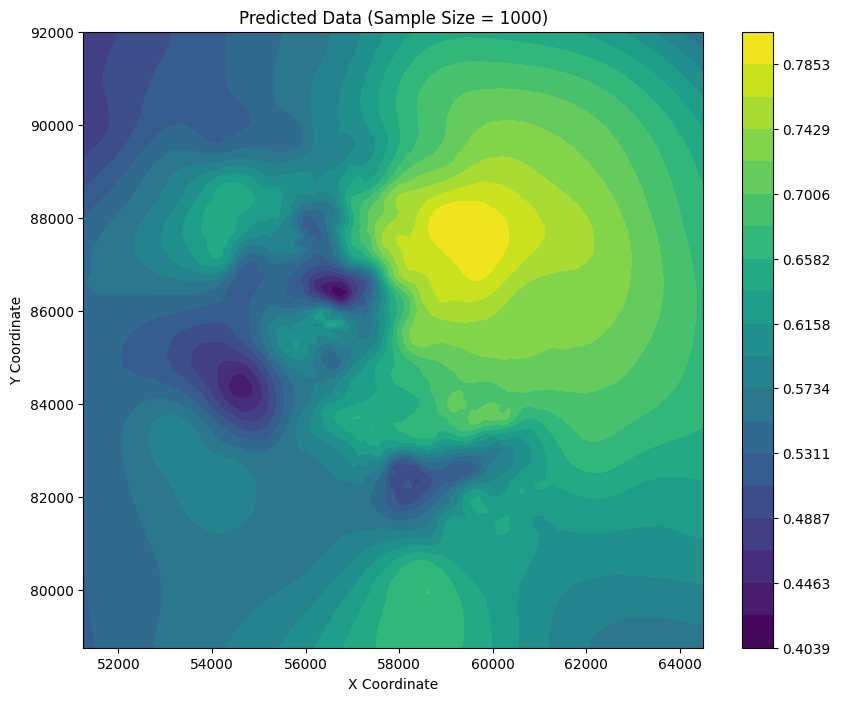

Sample Size = 1000:
  MSE: 0.000025
  RMSE: 0.004984
  MAE: 0.001668
--------------------------------------------------


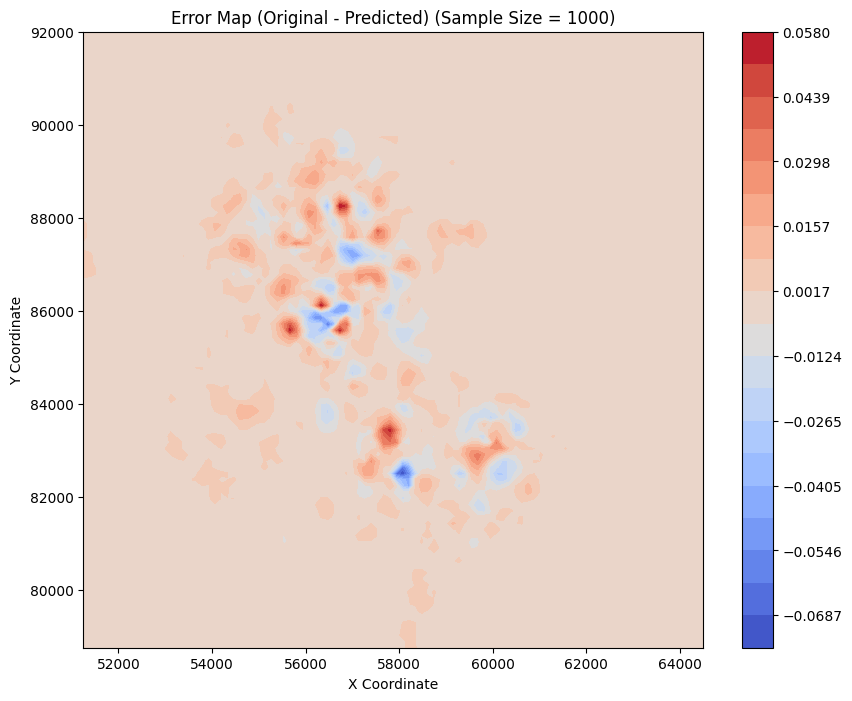

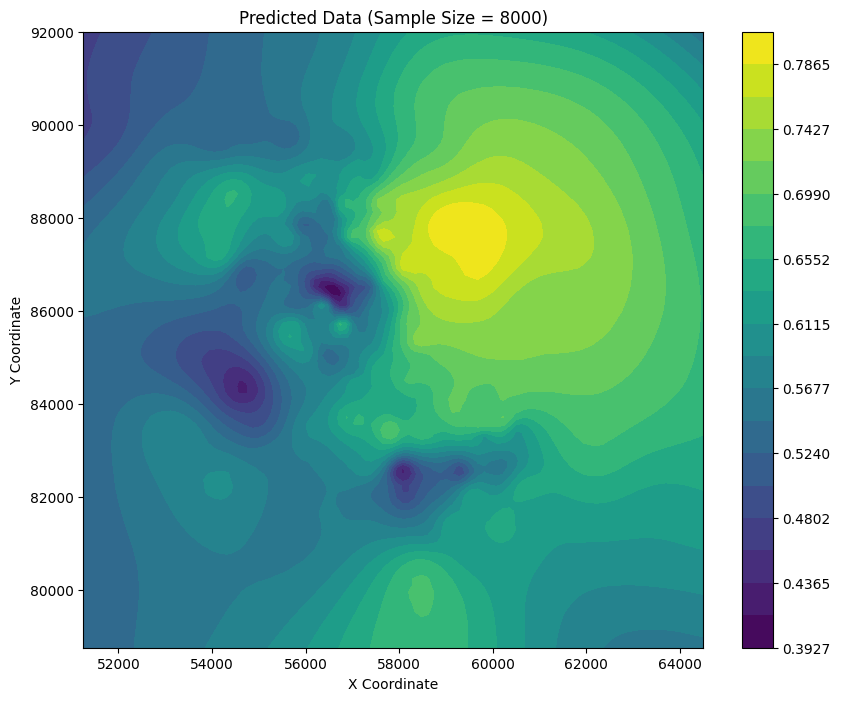

Sample Size = 8000:
  MSE: 0.000001
  RMSE: 0.000853
  MAE: 0.000252
--------------------------------------------------


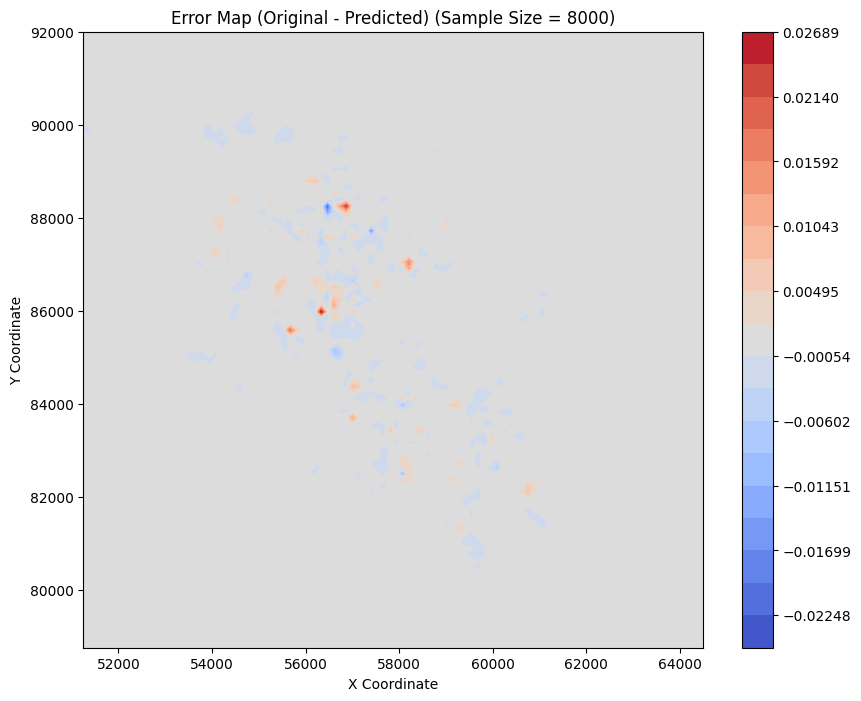

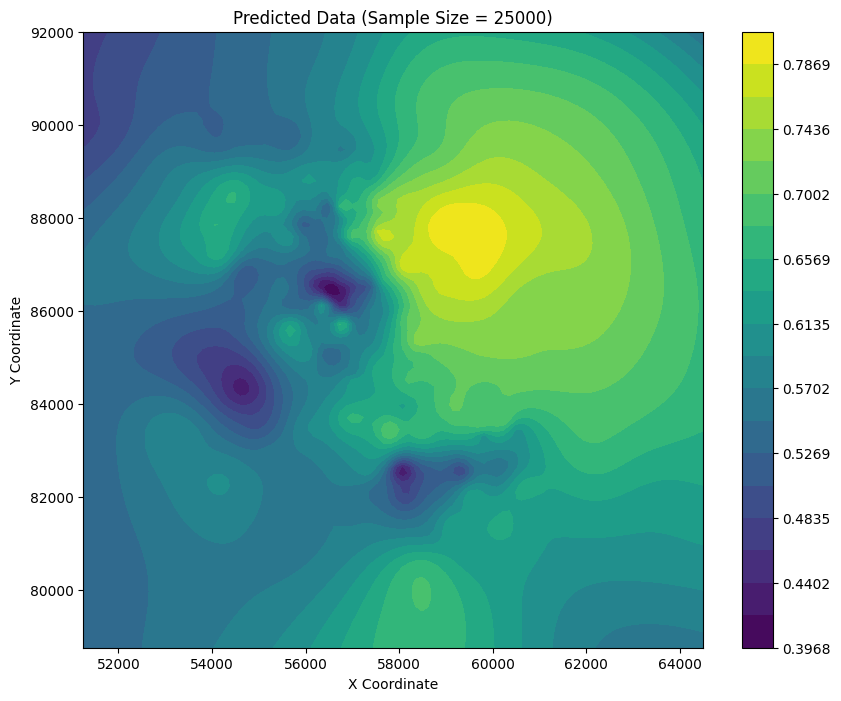

Sample Size = 25000:
  MSE: 0.000000
  RMSE: 0.000331
  MAE: 0.000106
--------------------------------------------------


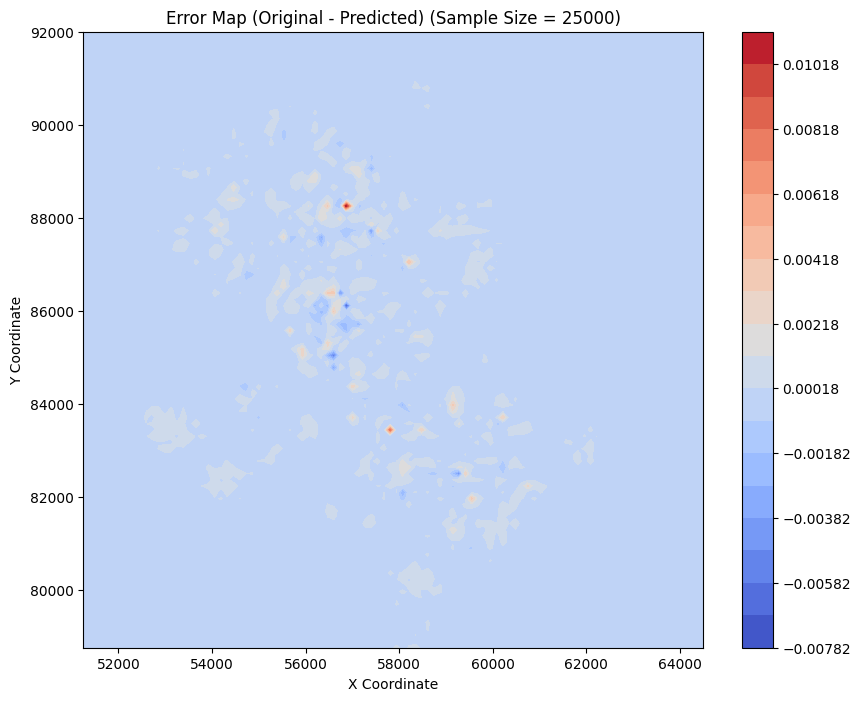

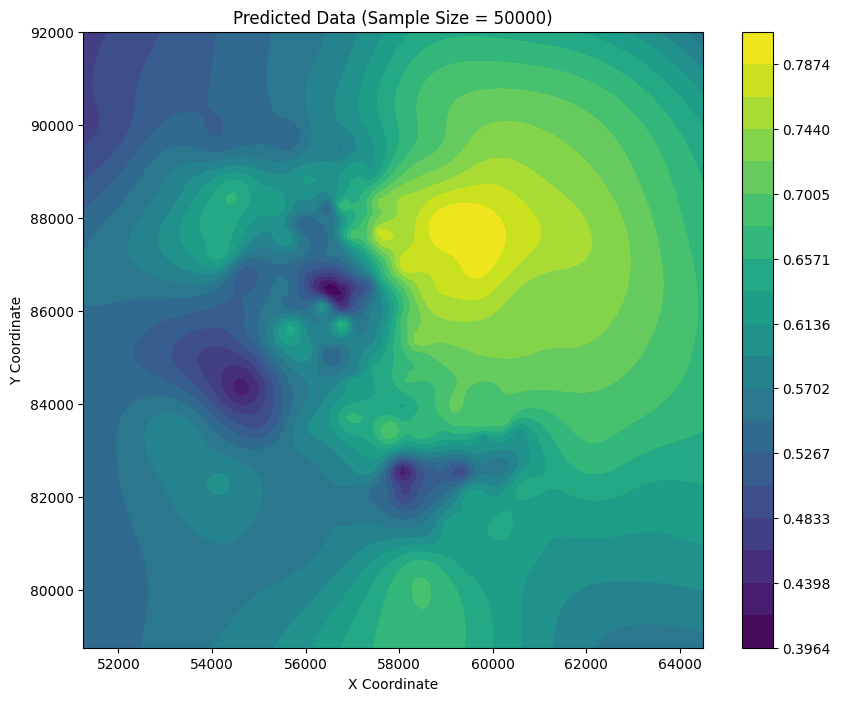

Sample Size = 50000:
  MSE: 0.000000
  RMSE: 0.000226
  MAE: 0.000069
--------------------------------------------------


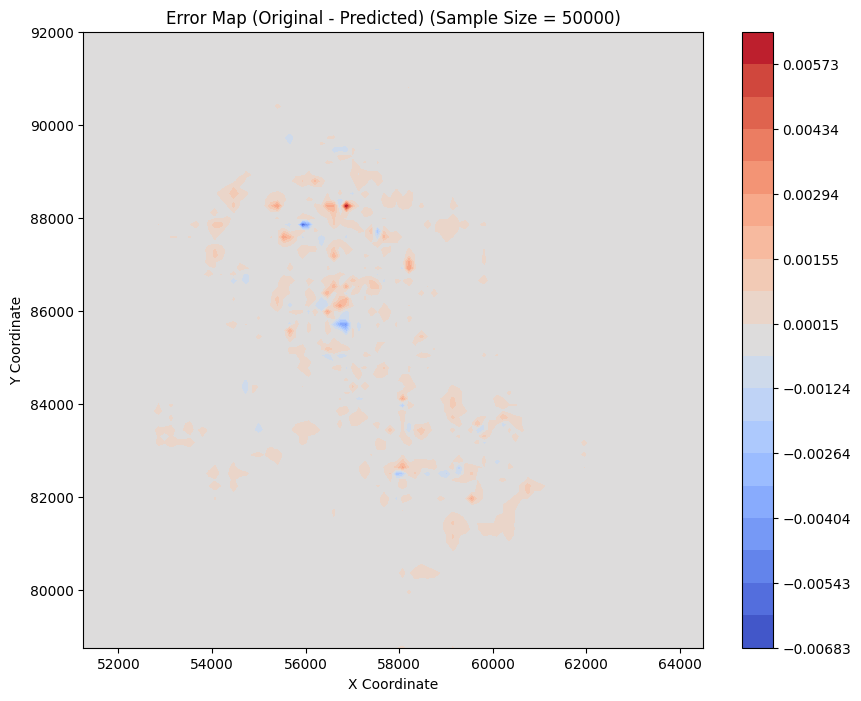

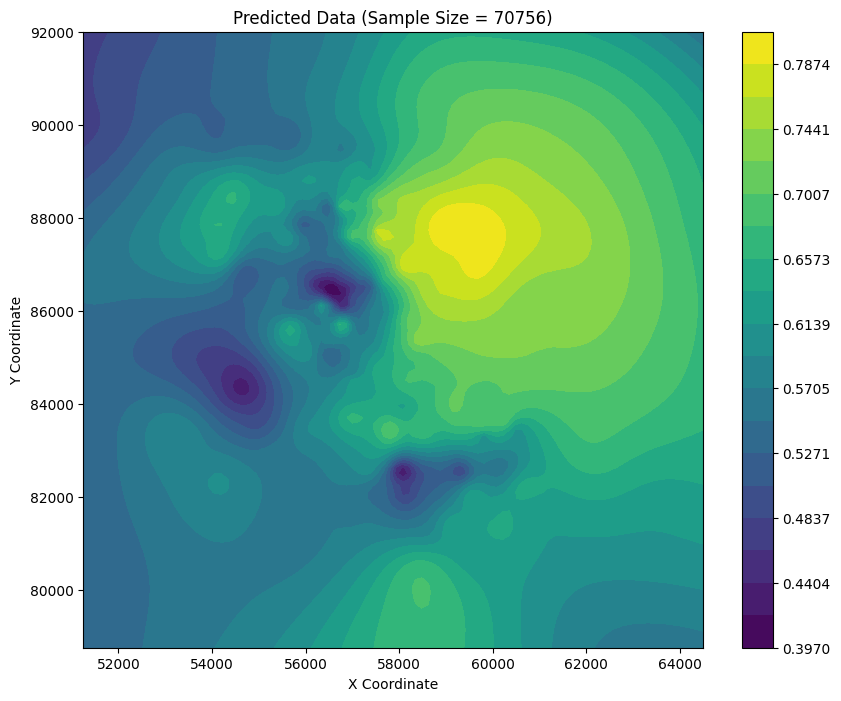

Sample Size = 70756:
  MSE: 0.000000
  RMSE: 0.000160
  MAE: 0.000049
--------------------------------------------------


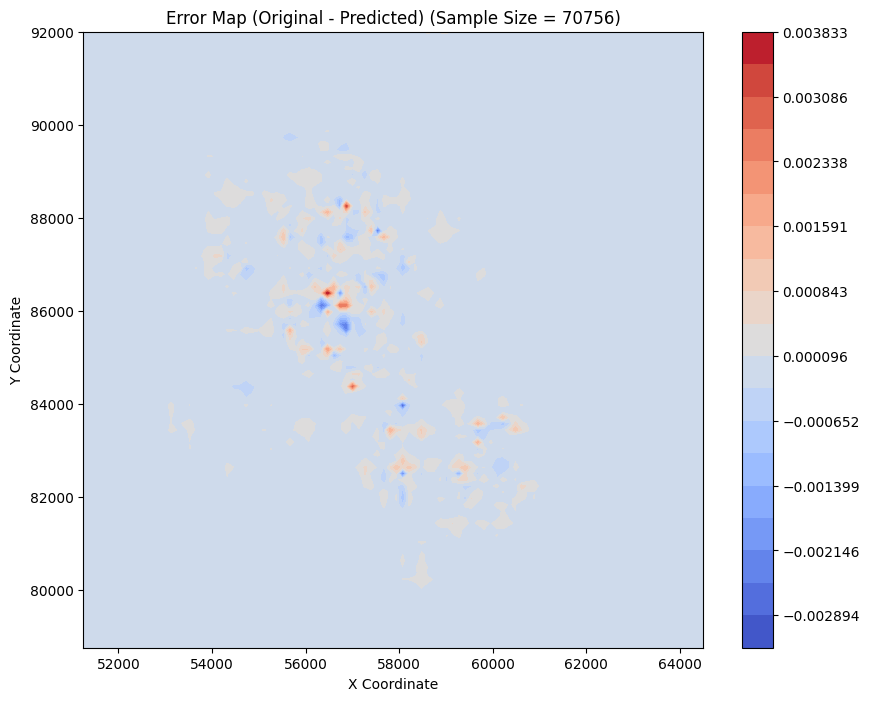

In [ ]:
# ------ 2. Prediction Plot ------ #

sample_sizes = [50, 200, 500, 1000, 8000, 25000, 50000, len(x)] 

for sample_size in sample_sizes:
    # Choose the number of closest points to use for interpolation (n_closest) based on the sample size
    n_closest = int(((sample_size+2000)**-1)*10000+10)  # This can be further examined and optimized based on the data
    
    # random sample
    grid_size = int(sqrt(sample_size))
    x_bins = np.linspace(x.min(), x.max(), grid_size + 1)
    y_bins = np.linspace(y.min(), y.max(), grid_size + 1)

    sample_indices = []
    for i in range(grid_size):
        for j in range(grid_size):
            x_bin_indices = (x >= x_bins[i]) & (x < x_bins[i + 1])
            y_bin_indices = (y >= y_bins[j]) & (y < y_bins[j + 1])
            bin_indices = np.where(x_bin_indices & y_bin_indices)[0]
            if len(bin_indices) > 0:
                sample_indices.append(np.random.choice(bin_indices))

    x_sample = x.iloc[sample_indices]
    y_sample = y.iloc[sample_indices]
    z_sample = z.iloc[sample_indices]
    selected_samples = {var: selected_data[var].iloc[sample_indices] for var in selected_variables}

    # Utilize the Universal Kriging method to interpolate the data
    # Utilize the cKDTree method to find the n_closest points for each grid point.
    # Which accelerates the interpolation process!!!
    tree = cKDTree(np.c_[x_sample, y_sample])
    zi_sample = np.zeros_like(xi)
    for i in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            distances, indices = tree.query([xi[i, j], yi[i, j]], k=n_closest)
            uk = UniversalKriging(
                x_sample.iloc[indices], y_sample.iloc[indices], z_sample.iloc[indices],
                variogram_model=selected_variogram_models[selected_variables[0]],  # use the variogram model of the first selected variable
                drift_terms=['regional_linear']
            )
            zi_sample[i, j], _ = uk.execute('points', xi[i, j], yi[i, j])

    plt.figure(figsize=(10, 8))
    levels = np.linspace(np.nanmin(zi_sample), np.nanmax(zi_sample), 20)
    contour = plt.contourf(xi, yi, zi_sample, levels=levels, cmap='viridis') 
    plt.colorbar(contour) 
    plt.title(f'Predicted Data (Sample Size = {sample_size})')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # save the predicted data as a png file
    plt.savefig(f'Predicted_Data_Sample_Size_{sample_size}.png')
    plt.show()

    # ------ 3. Error Computation and Plot ------ #
    zi_original = griddata((x, y), z, (xi, yi), method='linear')

    error = zi_original - zi_sample

    valid_indices = ~np.isnan(error.flatten()) 
    error_valid = error.flatten()[valid_indices]
    zi_original_valid = zi_original.flatten()[valid_indices]
    zi_sample_valid = zi_sample.flatten()[valid_indices]

    mse = mean_squared_error(zi_original_valid, zi_sample_valid)
    rmse = sqrt(mse)
    mae = mean_absolute_error(zi_original_valid, zi_sample_valid)

    print(f"Sample Size = {sample_size}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print("-" * 50)

    plt.figure(figsize=(10, 8))
    levels = np.linspace(np.nanmin(error_valid), np.nanmax(error_valid), 20)
    contour = plt.contourf(xi, yi, error, levels=levels, cmap='coolwarm')  
    plt.colorbar(contour) 
    plt.title(f'Error Map (Original - Predicted) (Sample Size = {sample_size})')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # save the error map as a png file
    plt.savefig(f'Error_Map_Sample_Size_{sample_size}.png')
    plt.show()

# *Investigate the best Variation Function Model

Test what best variation function model is for the whole 4 Variables.
And the result shows that all four variables should use the "Gaussian" Variable function.

In [ ]:
# mannually choose the sample size
selected_variables = ['variable1', 'variable2', 'variable3', 'variable4']  # 选择所有协作变量

variogram_models = ['gaussian', 'exponential', 'linear', 'spherical']

sample_size = [8000]

# initialize the results dictionary
results = {var: [] for var in selected_variables}

# ------ 2. Prediction Plot ------ #
# Choose the number of closest points to use for interpolation (n_closest) based on the sample size
n_closest = int(((sample_size+2000)**-1)*10000+10)  # This can be further examined and optimized based on the data

# random sample
grid_size = int(sqrt(sample_size))
x_bins = np.linspace(x.min(), x.max(), grid_size + 1)
y_bins = np.linspace(y.min(), y.max(), grid_size + 1)

sample_indices = []
for i in range(grid_size):
    for j in range(grid_size):
        x_bin_indices = (x >= x_bins[i]) & (x < x_bins[i + 1])
        y_bin_indices = (y >= y_bins[j]) & (y < y_bins[j + 1])
        bin_indices = np.where(x_bin_indices & y_bin_indices)[0]
        if len(bin_indices) > 0:
            sample_indices.append(np.random.choice(bin_indices))

x_sample = x.iloc[sample_indices]
y_sample = y.iloc[sample_indices]
z_sample = z.iloc[sample_indices]

# view all the selected variables
for variable in selected_variables:
    selected_sample = collaborative_variables[variable].iloc[sample_indices]

    # Utilize the cKDTree method to find the n_closest points for each grid point.
    # Which accelerates the interpolation process!!!
    tree = cKDTree(np.c_[x_sample, y_sample])

    for variogram_model in variogram_models:
        zi_sample = np.zeros_like(xi)
        for i in range(xi.shape[0]):
            for j in range(xi.shape[1]):
                distances, indices = tree.query([xi[i, j], yi[i, j]], k=n_closest)
                uk = UniversalKriging(
                    x_sample.iloc[indices], y_sample.iloc[indices], z_sample.iloc[indices],
                    variogram_model=variogram_model,  # Apply the chosen variogram model
                    drift_terms=['regional_linear']
                )
                zi_sample[i, j], _ = uk.execute('points', xi[i, j], yi[i, j])

        # ------ 3. Error Computation and Plot ------ #
        zi_original = griddata((x, y), z, (xi, yi), method='linear')

        error = zi_original - zi_sample

        valid_indices = ~np.isnan(error.flatten()) 
        error_valid = error.flatten()[valid_indices]
        zi_original_valid = zi_original.flatten()[valid_indices]
        zi_sample_valid = zi_sample.flatten()[valid_indices]

        mse = mean_squared_error(zi_original_valid, zi_sample_valid)
        rmse = sqrt(mse)
        mae = mean_absolute_error(zi_original_valid, zi_sample_valid)

        results[variable].append([mse, rmse, mae])

        print(f"Variable = {variable}, Variogram Model = {variogram_model}:")
        print(f"  MSE: {mse:.6f}")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print("-" * 50)

# print the results
for variable in selected_variables:
    print(f"Results for {variable} (MSE, RMSE, MAE for each variogram model):")
    print("Variogram Models: [Gaussian, Exponential, Linear, Spherical]")
    for i, metric in enumerate(['MSE', 'RMSE', 'MAE']):
        print(f"{metric}: {[result[i] for result in results[variable]]}")

Variable = variable1, Variogram Model = gaussian:
  MSE: 0.000001
  RMSE: 0.000875
  MAE: 0.000259
--------------------------------------------------
Variable = variable1, Variogram Model = exponential:
  MSE: 0.000002
  RMSE: 0.001428
  MAE: 0.000441
--------------------------------------------------
Variable = variable1, Variogram Model = linear:
  MSE: 0.000003
  RMSE: 0.001616
  MAE: 0.000346
--------------------------------------------------
Variable = variable1, Variogram Model = spherical:
  MSE: 0.000002
  RMSE: 0.001259
  MAE: 0.000367
--------------------------------------------------
Variable = variable2, Variogram Model = gaussian:
  MSE: 0.000001
  RMSE: 0.000875
  MAE: 0.000259
--------------------------------------------------
Variable = variable2, Variogram Model = exponential:
  MSE: 0.000002
  RMSE: 0.001428
  MAE: 0.000441
--------------------------------------------------
Variable = variable2, Variogram Model = linear:
  MSE: 0.000003
  RMSE: 0.001616
  MAE: 0.00034